In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.special import roots_legendre
from matplotlib import pyplot as plt
import math
from math import log, exp, sqrt, pi
from scipy.interpolate import interp1d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

/Users/rahulgupta/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


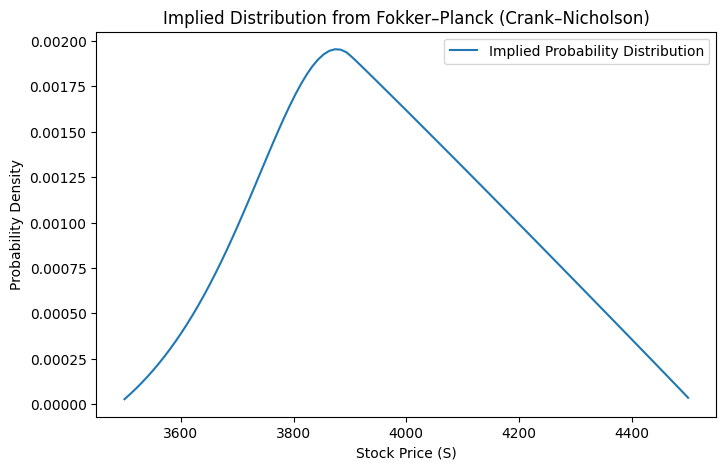

In [2]:
# -------------------------------
# 1. Load Local Volatility Function (Fixed)
# -------------------------------
K_vals = np.array([3900, 4000, 4100, 4200, 4300])  # Strike Prices
sigma_K = np.array([-10.0007, 81.9997, 125.0, 120.0, 116.0])  # Bad values

# Fix negative and extreme values before interpolation
sigma_K = np.clip(sigma_K, 0.05, 0.8)  # Enforce min 5%, max 80%

# Interpolate sigma(K) to be used for all asset prices S
local_vol_func = interp1d(K_vals, sigma_K, kind="cubic", fill_value="extrapolate")

# -------------------------------
# 2. Define Fokker–Planck Parameters
# -------------------------------
S_min, S_max = 3500, 4500  # Asset price range
N_S = 100  # Number of asset price grid points
S_vals = np.linspace(S_min, S_max, N_S)  # Discretized price grid
dS = S_vals[1] - S_vals[0]  # Step size in asset price space

T = 43 / 252  # Time to maturity in years
N_T = 50  # Number of time steps
dt = T / N_T  # Time step size
r = 0.05  # Risk-free rate

# -------------------------------
# 3. Construct Crank–Nicholson Matrices
# -------------------------------
sigma_vals = local_vol_func(S_vals)  # Compute sigma(S) at each grid point

# Ensure all vol values remain reasonable
sigma_vals = np.clip(sigma_vals, 0.05, 0.8)

alpha = (r / 2) * S_vals / dS  # Drift term
beta = (sigma_vals**2 * S_vals**2) / (2 * dS**2)  # Diffusion term

A_diag = -beta - alpha / 2
B_diag = -beta + alpha / 2
C_diag = 2 * beta + 1 / dt
D_diag = -2 * beta + 1 / dt

# Create sparse matrices
A = diags([A_diag[1:], C_diag, B_diag[:-1]], [-1, 0, 1], format="csr")  # Left matrix
B = diags([-A_diag[1:], D_diag, -B_diag[:-1]], [-1, 0, 1], format="csr")  # Right matrix

# -------------------------------
# 4. Initialize Probability Distribution
# -------------------------------
pdf = np.exp(-((S_vals - 4050) ** 2) / (2 * 200 ** 2))  # Gaussian initial guess
pdf /= np.sum(pdf * dS)  # Normalize to ensure total probability is 1

# -------------------------------
# 5. Solve the Fokker–Planck PDE Using Crank–Nicholson
# -------------------------------
for _ in range(N_T):
    b = B @ pdf  # Compute right-hand side
    pdf = spsolve(A, b)  # Solve linear system

# Normalize final probability distribution
pdf /= np.sum(pdf * dS)

# -------------------------------
# 6. Plot the Final Implied Probability Distribution
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S_vals, pdf, label="Implied Probability Distribution")
plt.xlabel("Stock Price (S)")
plt.ylabel("Probability Density")
plt.title("Implied Distribution from Fokker–Planck (Crank–Nicholson)")
plt.legend()
plt.show()